# Master Thesis Analysis Report

Analysis of the participants using two different user interfaces. Participants had to fill out S-UEQ, SUS and RAW-TLX after a task on Garmin and a task on Strava. Each participant represents 2 rows in a dataframe - one row represents self-reports for Garmin (1) and one for Strava (2). To do an analysis, data has to be split into 3 distinct questionnaires.

In [1]:
from analysis.analyzer import AnalysisManager
from data_manager.manager import DataManager
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

NOTE!! preden začneš delat z novimi podatki, uvoženimi iz 1ke, moraš zamenjat "=" in " s prazno. Lahko narediš v VSCju. 1. vrstica ima 2x 1 pri UI_category, 2. zamenjaj s 1. 97548 šifro mečemo ven

## Getting data ready

Reading data from a CSV file and changing values to numeric; column 1 is user ID, column 2 is category (1 - Garmin, 2 - Strava)

In [2]:
data_manager = DataManager(
    responses_data_path="anketa-01-13.csv", 
    pupil_data_path=None
    )

cleaned_data = data_manager.get_clean_data().iloc[2:,:]
cleaned_data.head(3)

,user_id,UI,Q4a,Q4b,Q4c,Q4d,Q4e,Q4f,Q4g,Q4h,...,Q6g,Q6h,Q6i,Q6j,Q8,Q9,Q10,Q11,Q12,Q13
2,29622,2,5,6,6,2,5,6,5,5,...,4,4,1,4,12,0,5,12,15,7
3,29622,1,6,6,6,7,3,5,6,6,...,5,1,4,2,8,0,5,5,8,2
4,94249,2,6,5,5,6,4,4,5,5,...,4,2,5,1,1,0,1,0,1,1


Checking for internal consistency of the questionnaire responses with Cronbach Alpha and its confidence intervals:

In [3]:
cronbach=data_manager.calculate_cronbach_alpha(cleaned_data)
cronbach

,Questionnaire,Cronbach's Alpha,CI Lower,CI Upper
0,UEQ Pragmatic Quality,0.8594,0.797,0.906
1,UEQ Hedonic Quality,0.8535,0.788,0.902
2,Overall UEQ Score,0.8513,0.792,0.899
3,SUS,-1.0082,-1.790,-0.374
4,NASA-TLX,0.7622,0.664,0.839


We can see that internal consistency of the questionnaires is sufficient.

Splitting data into:
* short-user experience questionnaire (SUEQ)
* system usability scale (SUEQ)
* NASA task load index (NASA-TLX)

In [4]:
sueq, sus, tlx = data_manager.split_data()
questionnaire_dict= {"SUEQ" : sueq, 
                     "SUS" : sus, 
                     "TLX" : tlx}
sueq.head(3)
tlx

,user_id,UI,Q8,Q9,Q10,Q11,Q12,Q13
0,83213,1,5,0,3,2,8,7
1,83213,2,5,0,2,1,1,1
2,29622,2,12,0,5,12,15,7
3,29622,1,8,0,5,5,8,2
4,94249,2,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...
67,70885,2,5,1,6,7,5,13
68,26286,1,8,3,6,1,6,3
69,26286,2,1,2,2,1,3,1
70,74495,2,1,1,1,0,1,3


## Scoring data
Initializing class Analysis and performing a scoring on each questionnaire.

In [5]:
analyst=AnalysisManager(sueq, sus, tlx)

In [6]:
score_tlx=analyst.score_tlx()
score_tlx.head()
stat,p=stats.shapiro(score_tlx)
print(p)
analyst.accept_normality(p)



5.7899767300331215e-21


np.False_

In [7]:
score_sus=analyst.score_sus()
score_sus.head()
stat,p=stats.shapiro(score_sus)
analyst.accept_normality(p)


np.False_

In [8]:
score_sueq=analyst.score_ueq_short()
score_sueq.head()
stat,p=stats.shapiro(score_sueq)
analyst.accept_normality(p)

np.False_

In [9]:
combined_scores=analyst.combine_scores(score_sueq, score_sus, score_tlx)
combined_scores

,User ID,Interface Category,Overall Pragmatic Quality,Overall Hedonic Quality,Overall UEQ Score,Mean SUS Score,Mean TLX Score
0,14076,1,4.75,3.00,3.875,50.0,3.000000
1,14076,2,3.00,4.00,3.500,57.5,5.833333
2,14230,1,6.25,5.75,6.000,92.5,1.833333
3,14230,2,5.50,5.25,5.375,80.0,3.166667
4,15629,1,4.00,3.75,3.875,62.5,5.000000
...,...,...,...,...,...,...,...
67,94249,2,5.50,4.50,5.000,80.0,0.666667
68,96066,1,5.00,5.50,5.250,82.5,1.166667
69,96066,2,3.75,3.25,3.500,35.0,5.666667
70,99096,1,5.25,5.00,5.125,62.5,3.833333


In [10]:
calculate_stats=analyst.calculate_statistics(combined_scores, ('Overall Pragmatic Quality', 'Overall Hedonic Quality', 'Overall UEQ Score', 'Mean SUS Score', 'Mean TLX Score'))
calculate_stats

,Measure,Mean,Standard Deviation,Median,IQR
0,Overall Pragmatic Quality,4.71,1.27,5.0000,1.88
1,Overall Hedonic Quality,4.55,1.13,4.7500,1.50
2,Overall UEQ Score,4.63,1.01,4.6875,1.50
3,Mean SUS Score,66.15,20.59,67.5000,33.12
4,Mean TLX Score,4.19,2.87,4.0000,4.71


In [11]:
calculate_stats_by = analyst.calculate_statistics_by(df=combined_scores, group_col= 'Interface Category', columns= ('Overall Pragmatic Quality', 'Overall Hedonic Quality', 'Overall UEQ Score', 'Mean SUS Score', 'Mean TLX Score'))
calculate_stats_by

,Interface Category,Measure,Mean,Standard Deviation,Median,IQR
0,1,Overall Pragmatic Quality,4.70,1.39,4.875,2.25
1,1,Overall Hedonic Quality,4.76,1.24,5.000,1.38
2,1,Overall UEQ Score,4.73,1.08,4.750,1.75
3,1,Mean SUS Score,66.18,22.08,66.250,32.50
4,1,Mean TLX Score,4.29,3.00,4.250,4.29
5,2,Overall Pragmatic Quality,4.72,1.17,5.125,1.81
6,2,Overall Hedonic Quality,4.35,0.99,4.500,1.56
7,2,Overall UEQ Score,4.53,0.94,4.500,1.44
8,2,Mean SUS Score,66.11,19.30,70.000,35.00
9,2,Mean TLX Score,4.09,2.77,3.750,4.92


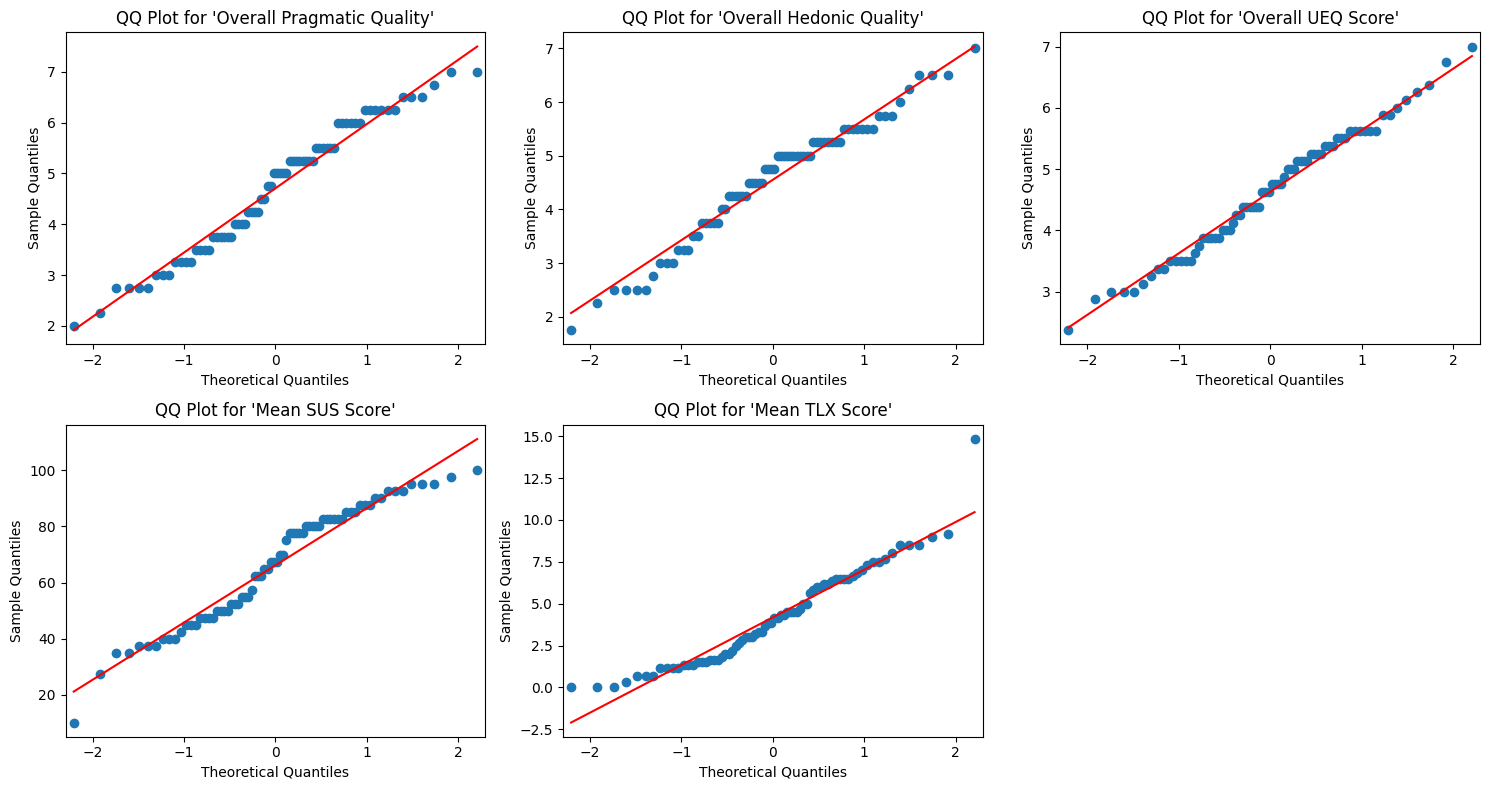

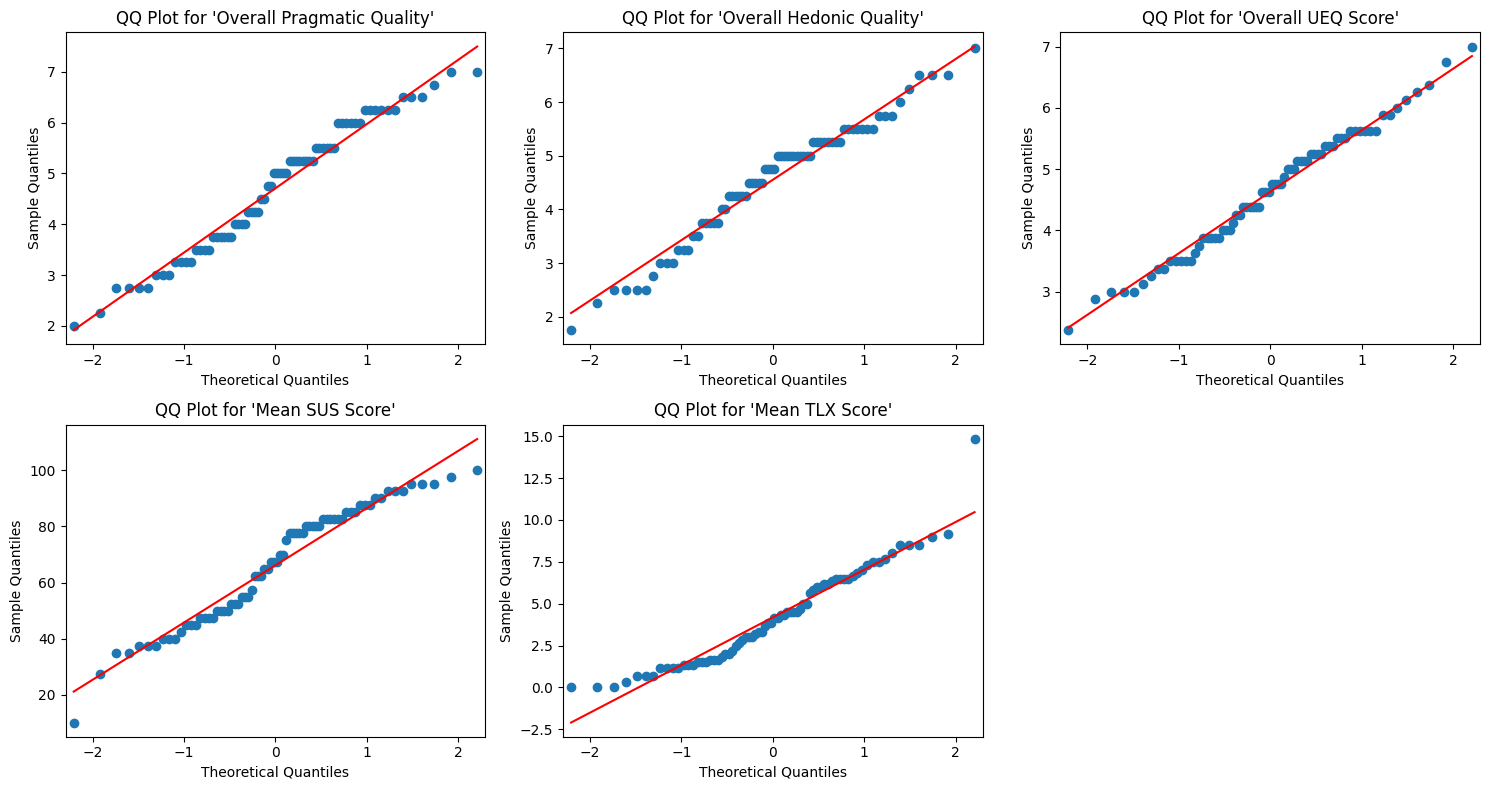

In [12]:
analyst.show_qq(combined_scores, ('Overall Pragmatic Quality', 'Overall Hedonic Quality', 'Overall UEQ Score', 'Mean SUS Score', 'Mean TLX Score'))

In [13]:
combined_scores.to_csv('combined_scores.csv', index=False)

## Visualizing data
Below is a chart of average scores on Questionnaires based on Interface. From the visualization alone we can see no significant difference in scores depending on interface

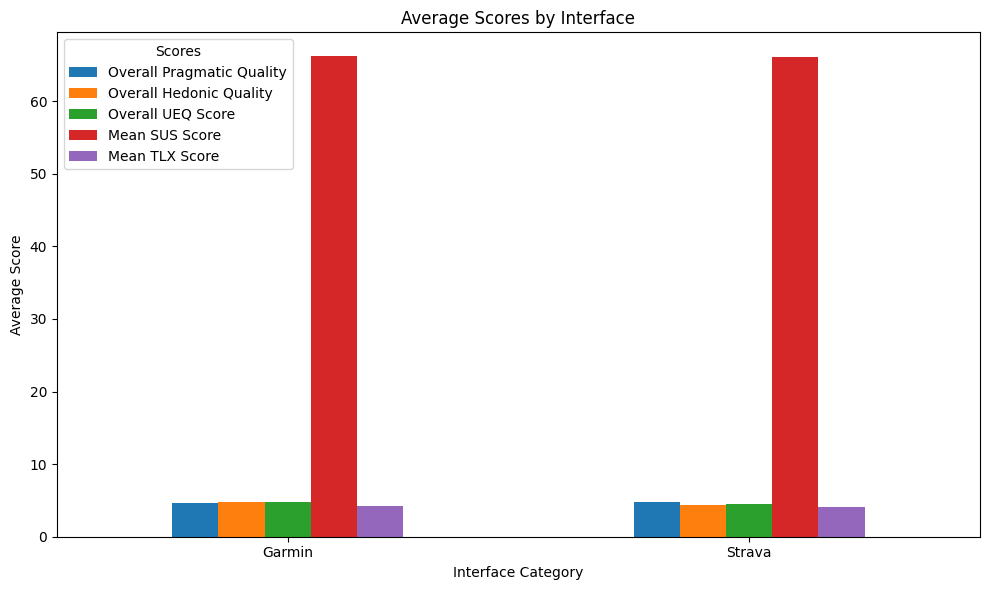

In [14]:
analyst.visualize_scores(combined_scores)

We performed Wilcoxon signed-rank test analysis for repeated measures to compare the scores of the two groups. The results are as follows:

In [15]:
analyst.wilcoxon(combined_scores)

,Measure,Test Statistic,P-Value
0,Overall Pragmatic Quality,289.0,0.8844
1,Overall Hedonic Quality,184.0,0.0843
2,Overall UEQ Score,272.0,0.4809
3,Mean SUS Score,271.0,0.8651
4,Mean TLX Score,306.0,0.8828


No significant relationship between interface and its questionnaire scores was found. 

## Combining questionnaire data with interface order and perceived difficulty
In the experiment, we used random order in which interfaces were presented, together with the question "Which interface did you find harder to solve the task on
?" [slov. Na katerem vmesniku je bilo težje reševati nalogo?] at the end of the whole experiment. 
* UI order ; 1 means interface was presented first, 2 means it was presented second
* UI rank; interface was ranked so that 1 means harder than 2

Adding information about gender and checking for relationships between gender and questionnaire answers

In [16]:
full_data=pd.read_csv("updated_combined_scores.csv", delimiter=";")
full_data

,User ID,Interface Category,UI order,UI rank,Overall Pragmatic Quality,Overall Hedonic Quality,Overall UEQ Score,Mean SUS Score,Mean TLX Score
0,14230,1,2,2,6.25,5.75,6.000,92.5,1.833333
1,14230,2,1,1,5.50,5.25,5.375,80.0,3.166667
2,15629,1,1,1,4.00,3.75,3.875,62.5,5.000000
3,15629,2,2,2,6.00,5.00,5.500,80.0,3.666667
4,16063,1,1,1,5.00,4.25,4.625,82.5,6.500000
...,...,...,...,...,...,...,...,...,...
67,70885,2,2,2,5.25,4.25,4.750,67.5,6.166667
68,26286,1,1,1,4.00,3.00,3.500,52.5,4.500000
69,26286,2,2,2,5.25,5.00,5.125,85.0,1.666667
70,74495,1,2,1,3.25,4.75,4.000,47.5,3.333333


checking for variance homogenity. If the p-value is less than 0.05, the variances are not equal.

In [17]:
analyst.levene_test(full_data, ('Overall Pragmatic Quality', 'Overall Hedonic Quality', 'Overall UEQ Score', 'Mean SUS Score', 'Mean TLX Score'), ('Interface Category', 'UI order', 'UI rank'),'median')

,Grouping Column,Value Column,Levene Statistic,p-value
0,Overall Pragmatic Quality,Interface Category,0.830792,0.657474
1,Overall Pragmatic Quality,UI order,0.482090,0.954909
2,Overall Pragmatic Quality,UI rank,0.685116,0.809904
3,Overall Hedonic Quality,Interface Category,0.526045,0.937427
4,Overall Hedonic Quality,UI order,0.573486,0.908262
5,Overall Hedonic Quality,UI rank,0.438516,0.974481
6,Overall UEQ Score,Interface Category,0.682702,0.858407
7,Overall UEQ Score,UI order,0.438394,0.988980
8,Overall UEQ Score,UI rank,0.415351,0.992518
9,Mean SUS Score,Interface Category,0.382493,0.994700


Checking if the participant's gender affects the data through correlating scores and gender:

In [18]:
score_columns = [
    'Overall Pragmatic Quality',
    'Overall Hedonic Quality',
    'Overall UEQ Score',
    'Mean SUS Score',
    'Mean TLX Score'
]
independent_variables = ['Interface Category', 'UI rank', 'UI order', 'Gender']

list_females=[
    83213, 63367, 60734, 37786, 74931, 16836, 39081, 62968, 84586, 16063,
    31434, 15629, 24603, 40280, 69163, 14076, 96066, 70885, 26286
]
data_manager.assign_gender(full_data, list_females)
analyst.gender_cor(full_data, score_columns)

,Score Column,Correlation (r),P-Value
0,Overall pragmatic quality,0.0186,0.8765
1,Overall hedonic quality,0.0480,0.6886
2,Overall ueq score,0.0387,0.7469
3,Mean sus score,0.0512,0.6695
4,Mean tlx score,0.0568,0.6358


Calculating proportions of each interface based on perceived difficulty:

In [19]:
full_data['UI rank'].value_counts(1)

UI rank
2    0.5
1    0.5
Name: proportion, dtype: float64

Calculating statistics based on perceived difficulty: 

In [20]:
calculate_stats_by_rank=analyst.calculate_statistics_by(df=full_data, group_col= 'UI rank', columns= ('Overall Pragmatic Quality', 'Overall Hedonic Quality', 'Overall UEQ Score', 'Mean SUS Score', 'Mean TLX Score'))
calculate_stats_by_rank

,UI rank,Measure,Mean,Standard Deviation,Median,IQR
0,1,Overall Pragmatic Quality,4.27,1.20,4.0000,1.62
1,1,Overall Hedonic Quality,4.20,1.19,4.3750,2.00
2,1,Overall UEQ Score,4.24,0.99,4.0625,1.53
3,1,Mean SUS Score,59.17,20.51,51.2500,33.12
4,1,Mean TLX Score,4.95,3.23,5.0000,3.96
5,2,Overall Pragmatic Quality,5.18,1.20,5.3750,1.19
6,2,Overall Hedonic Quality,4.93,0.95,5.0000,1.06
7,2,Overall UEQ Score,5.06,0.86,5.1250,1.06
8,2,Mean SUS Score,73.40,18.16,78.7500,25.00
9,2,Mean TLX Score,3.13,2.52,2.7500,3.25


In [21]:

#Compute Cohen's d for Interface Category
cohen_d_interface_category = analyst.calculate_wilcox(full_data, 'Interface Category', score_columns)
print("W statistic by Interface Category: 1 means Garmin whereas 2 means Strava")
print(cohen_d_interface_category)

#Compute W statistic for UI Order
cohen_d_ui_order = analyst.calculate_wilcox(full_data, 'UI order', score_columns)
print("\nW statistic by UI Order: 1 means it was presented first, 2 means it was presented second")
print(cohen_d_ui_order)

#Compute W statistic for UI Ranking
cohen_d_ui_ranking = analyst.calculate_wilcox(full_data, 'UI rank', score_columns)
print("\nW statistic by UI Ranking: 1 means it was ranked as harder, 2 means it was ranked as easier")
print(cohen_d_ui_ranking)


W statistic by Interface Category: 1 means Garmin whereas 2 means Strava
                     Measure   Grouping Variable  Group 1  Group 2  \
0  Overall Pragmatic Quality  Interface Category        1        2   
1    Overall Hedonic Quality  Interface Category        1        2   
2          Overall UEQ Score  Interface Category        1        2   
3             Mean SUS Score  Interface Category        1        2   
4             Mean TLX Score  Interface Category        1        2   

   Rank-Biserial Correlation  
0                  -0.049911  
1                   0.327652  
2                   0.117647  
3                   0.017045  
4                  -0.015126  

W statistic by UI Order: 1 means it was presented first, 2 means it was presented second
                     Measure Grouping Variable  Group 1  Group 2  \
0  Overall Pragmatic Quality          UI order        2        1   
1    Overall Hedonic Quality          UI order        2        1   
2          Overall UEQ Sco

Effect size is neglible for all independent variables but shows moderate effect in UI rank; interface perceived as harder scores lower on all questionnaires and subquestionnaires (UEQ, SUS) but higher on TLX, suggesting user experience is worse while perceived load is higher in interface subjectively perceived as harder. 

In [22]:
correlations, wilcox =analyst.correlations_and_wilcox(full_data)

We did an exploratory data analysis by correlating different variables. We were interested in the following relationships:
* is there a correlation between the order in which the interface was presented and perceived difficulty of task solving
* is there a correlation between the order in which the interface was presented and its scores on the questionnaires
* is there a correlation between the ranking of the interface and its scores on the questionnaires

For correlating UI order and UI rank, phi coefficient was used. For correlating UI order and UI rank with questionnaire scores, point biserial was used

In [23]:
corr_table, wilcox_table =analyst.present_findings(correlations, wilcox)
corr_table

,Relationship,Correlation (r),P-Value
0,UI rank ↔ UI order,0.25,Phi coefficient (no p-value)
1,UI rank ↔ Overall Pragmatic Quality,0.36**,0.0020
2,UI order ↔ Overall Pragmatic Quality,-0.16,0.1904
3,UI rank ↔ Overall Hedonic Quality,0.32**,0.0054
4,UI order ↔ Overall Hedonic Quality,0.06,0.5878
5,UI rank ↔ Overall UEQ Score,0.41**,0.0004
6,UI order ↔ Overall UEQ Score,-0.06,0.6028
7,UI rank ↔ Mean SUS Score,0.35**,0.0026
8,UI order ↔ Mean SUS Score,-0.05,0.6595
9,UI rank ↔ Mean TLX Score,-0.31**,0.0092


Correlation between UI rank and UI order is fairly weak. UI rank correlates significantly with overall pragmatic and hedonic quality, overall UEQ score and mean SUS score. However we can see that effect size is quite small. 

In [24]:
wilcox_table

,Measure,Grouping Variable,Wilcoxon Statistic (W),P-Value
0,Overall Pragmatic Quality,UI rank,120.00**,0.0041
1,Overall Hedonic Quality,UI rank,118.00**,0.0063
2,Overall UEQ Score,UI rank,97.50**,0.0006
3,Mean SUS Score,UI rank,104.00**,0.0028
4,Mean TLX Score,UI rank,118.00**,0.0012
5,Overall Pragmatic Quality,UI order,206.50,0.1858
6,Overall Hedonic Quality,UI order,231.50,0.5428
7,Overall UEQ Score,UI order,267.00,0.6018
8,Mean SUS Score,UI order,249.00,0.7790
9,Mean TLX Score,UI order,268.00,0.4413


The Wilcoxon signed-rank test was conducted to compare questionnaire scores with UI rank and UI order. There was a significant difference in scores depending on perceived difficulty of the interface. 

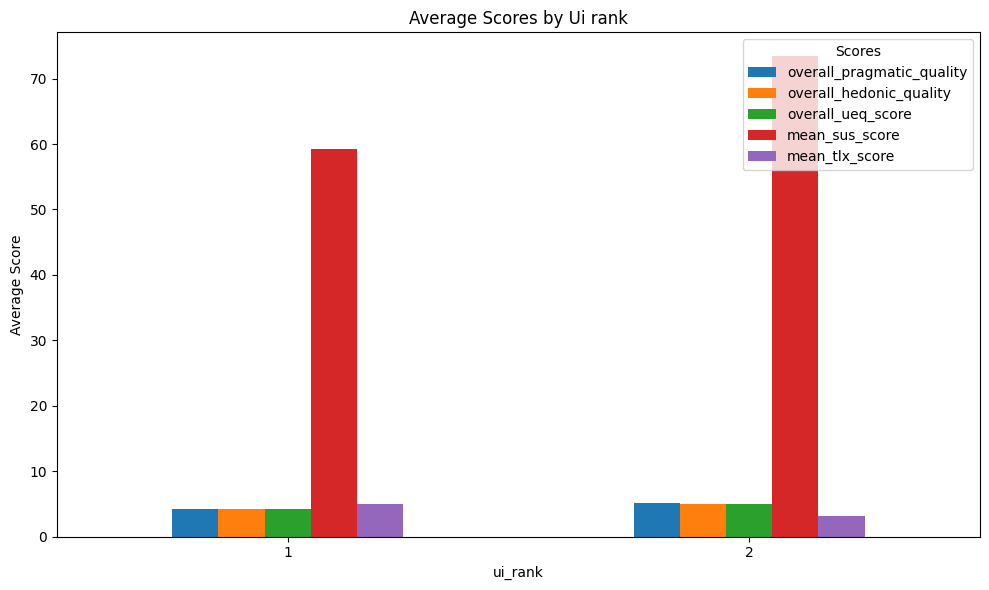

In [25]:
analyst.visualize_scores_by(full_data, 'UI rank')

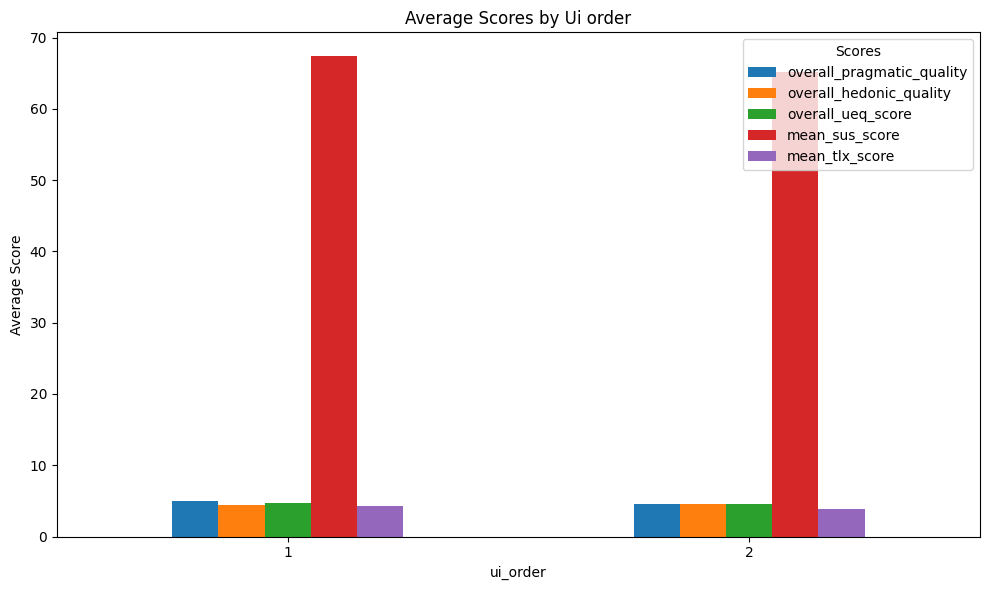

In [26]:
analyst.visualize_scores_by(full_data, 'UI order')

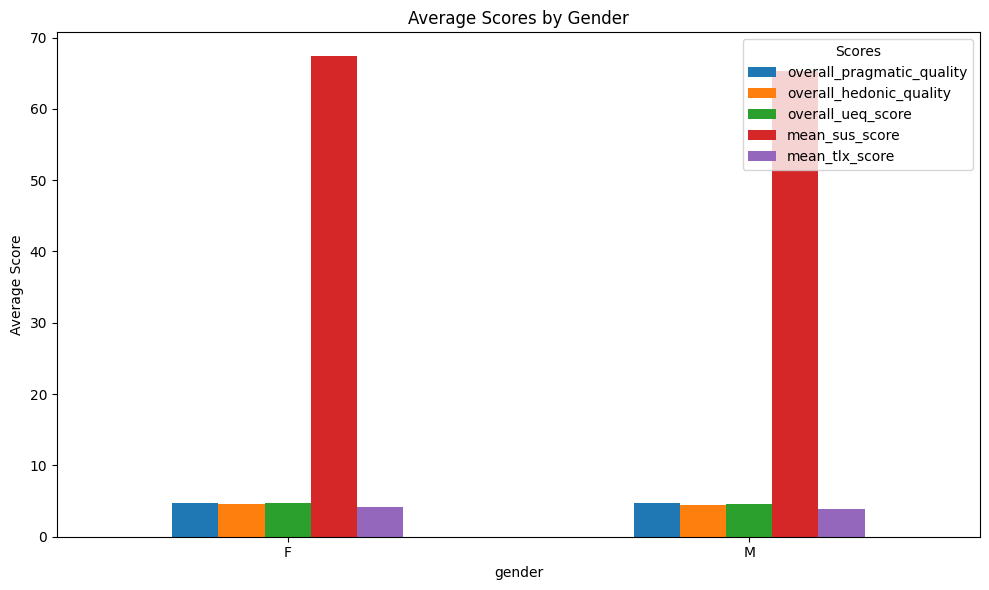

In [27]:
analyst.visualize_scores_by(full_data, 'Gender')

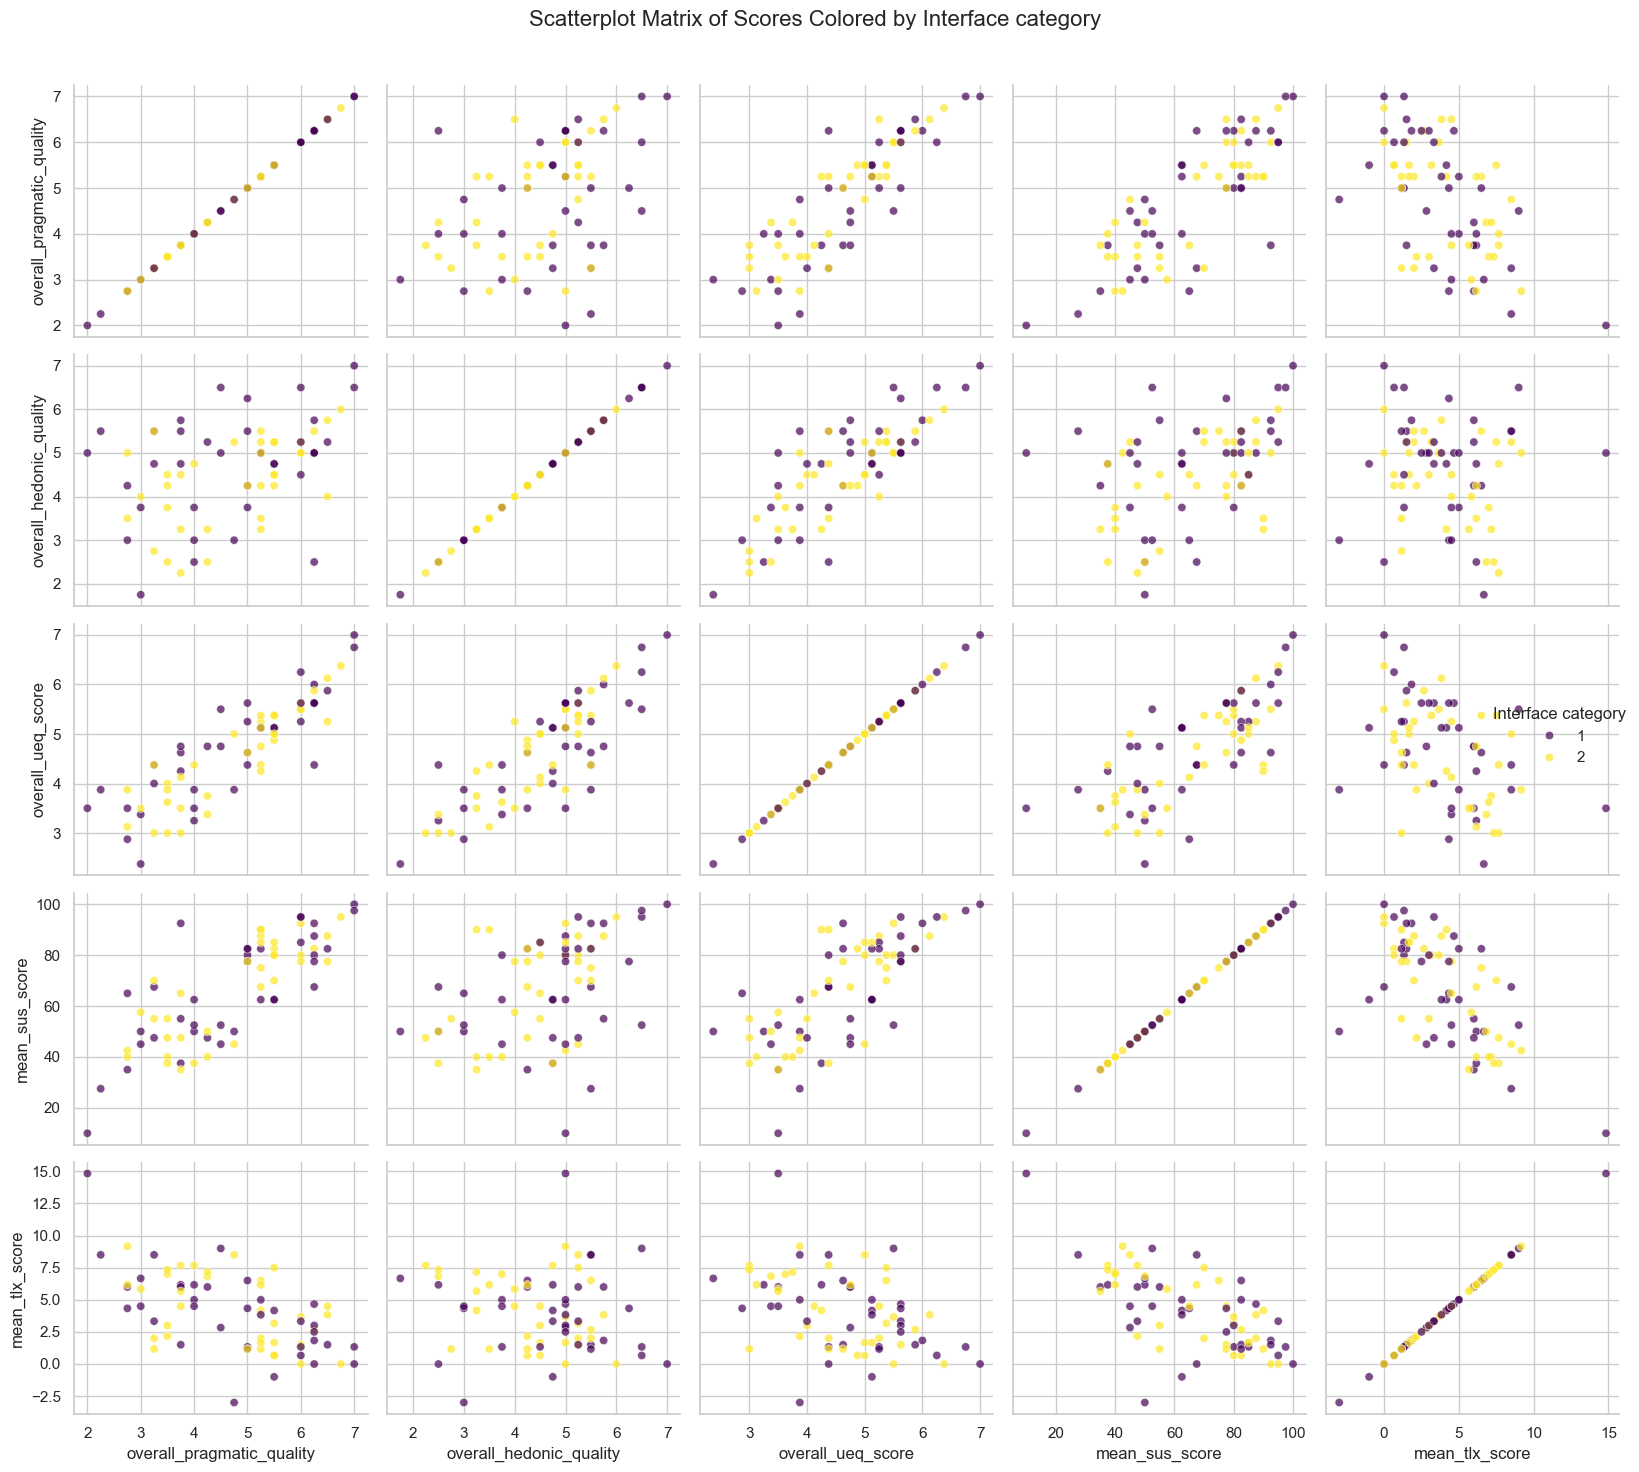

In [28]:
analyst.scatter_matrix(full_data, score_columns, 'Interface Category')

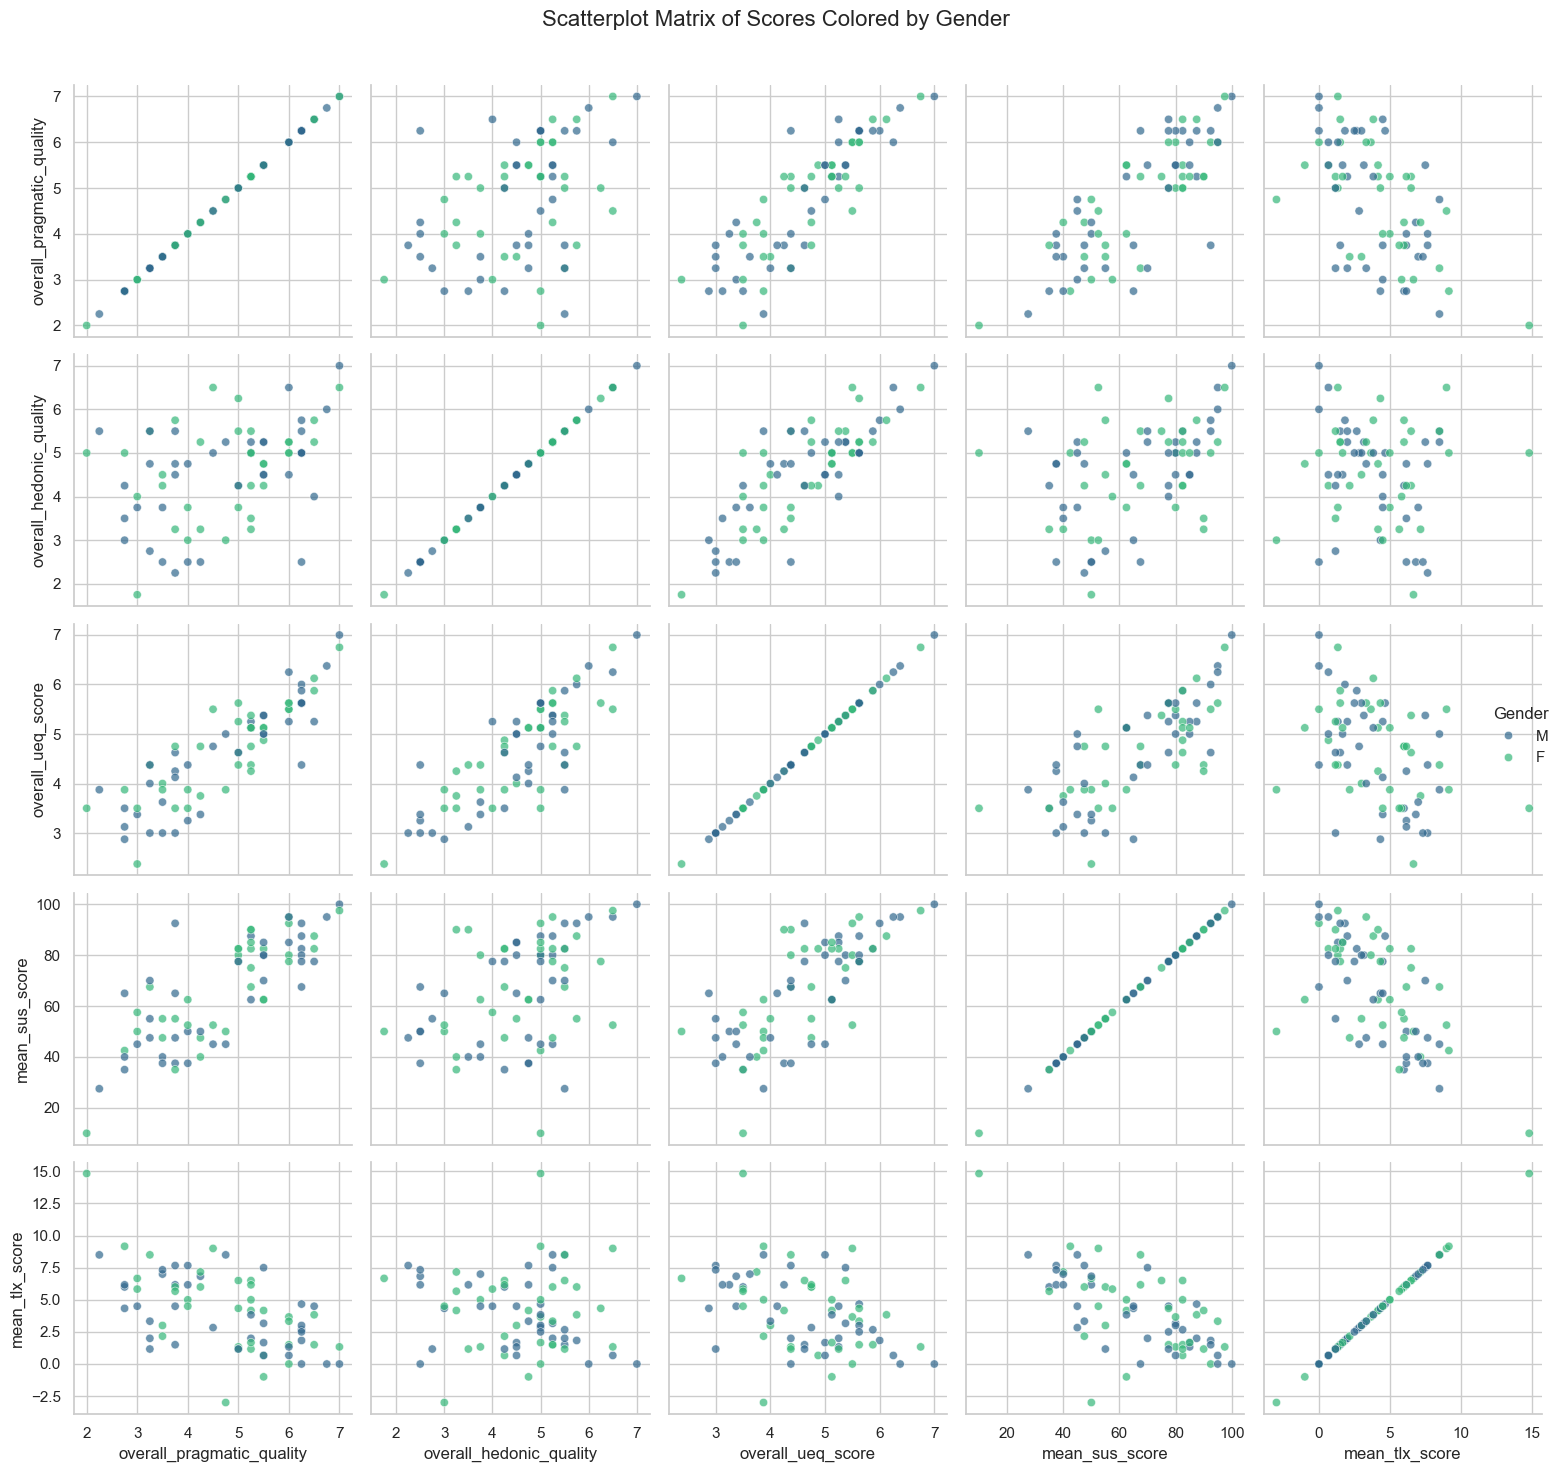

In [29]:
analyst.scatter_matrix(full_data, score_columns, 'Gender')

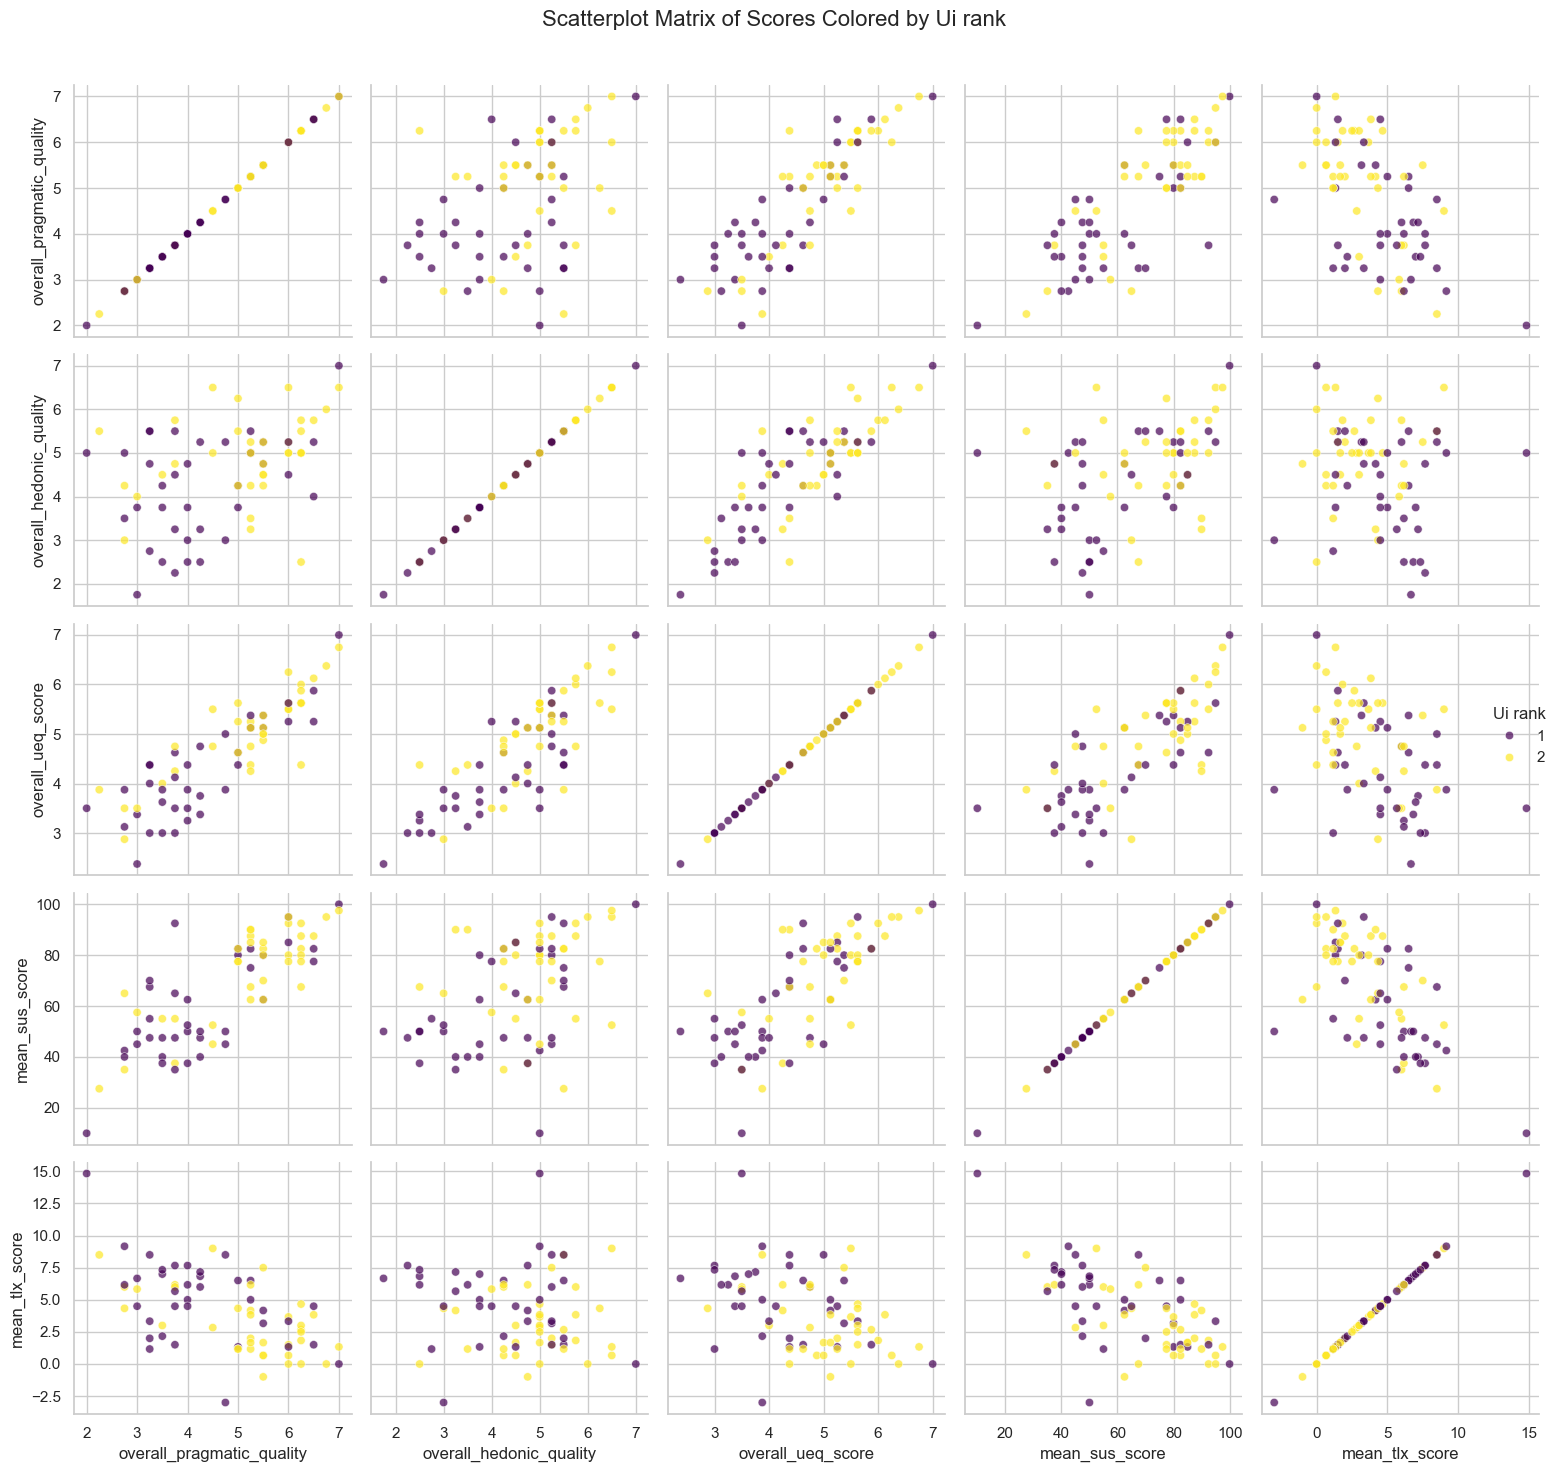

In [30]:
analyst.scatter_matrix(full_data, score_columns, 'UI rank')

RELATIONSHIPS BETWEEN QUESTIONNAIRES: 

* Pragmatic and Hedonic quality show a somehow linear-resembling relationship with UEQ but a scattered relationship between eachother
* Hedonic quality shows must scattered relationships with other Questionnaires
* TLX shows negative relationship with other questionnaires; when score on TLX is higher, the scores on other questionnaires are lower; except in Hedonic 

OBSERVING INDEPENDENT VARIABLES:
* Interface Category - Garmin (purple) generally takes up more extreme values than Strava
* Gender - Females show more variable scores
* UI Rank - for all questionnaires except TLX, scores are lower when interface is perceived as harder - it is the opposite for TLX, where scores are higher for harder perceived interface